In [2]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import cooler
import umap
import anndata
import harmonypy as hm
from itertools import cycle, islice

import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize, OneHotEncoder

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import cooltools.lib.plotting

from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from concurrent.futures import ProcessPoolExecutor, as_completed

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gene score annotation

In [19]:
from ALLCools.clustering import significant_pc_test

In [20]:
### load gene score
gene_hdf = []
for file in [file for file in os.listdir("../impute/genescore/") if file.endswith('.hdf')]:
    tmp = pd.read_hdf("../impute/genescore/" + file)
    gene_hdf.append(tmp)
    
gene_hdf = pd.concat(gene_hdf, axis=0)
print(gene_hdf.shape)

(84057, 36559)


In [23]:
### heart cell only
gene_hdf = gene_hdf[~gene_hdf.index.str.startswith(('LV009', 'LV012'))]
print(gene_hdf.shape)

(69683, 36559)


In [55]:
from scipy.io import mmwrite
from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(gene_hdf.values)
mmwrite('integration/FNIH_DHC_genescore.mtx', sparse_matrix)
gene_hdf.index.to_series().to_csv("integration/FNIH_DHC_genescore.barcodes.csv", header=False)
gene_hdf.columns.to_series().to_csv("integration/FNIH_DHC_genescore.features.csv", header=False)

In [25]:
res = 10000
gene_meta_path = '/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.txt'
gene_meta = pd.read_csv(gene_meta_path, names = ['chrom', 'start', 'end', 'gene_id', 'gene_name'], index_col='gene_id', sep='\s+')
gene_meta['bin_len'] = (gene_meta['end'] // res) - (gene_meta['start'] // res) + 1
gene_meta['weight'] = (gene_meta['bin_len']+2) * (gene_meta['bin_len'] + 1) / 2

chrom_size_path = '/projects/ps-renlab/y2xie/projects/genome_ref/hg38.main.chrom.sizes'
chromsize = pd.read_csv(chrom_size_path, sep='\t', header=None, index_col=0)
gene_meta = gene_meta[gene_meta['chrom'].isin(chromsize.index)]
gene_meta.head()

,chrom,start,end,gene_name,bin_len,weight
gene_id,,,,,,
ENSG00000243485,chr1,29554,31109,MIR1302-2HG,2,6.0
ENSG00000237613,chr1,34554,36081,FAM138A,1,3.0
ENSG00000186092,chr1,65419,71585,OR4F5,2,6.0
ENSG00000238009,chr1,89295,133723,AL627309.1,6,28.0
ENSG00000239945,chr1,89551,91105,AL627309.3,2,6.0


In [26]:
stat = []
for file in [file for file in os.listdir("../03.mapping/") if file.endswith('.sc.stat.csv')]:
    fname = file[0:5]
    tmp = pd.read_csv('../03.mapping/' + file, sep = '\t', index_col = 0)
    tmp.index = fname + '_' + tmp.index
    stat.append(tmp)
    
stat = pd.concat(stat, axis=0)
print(stat.shape)

(7798443, 9)


In [27]:
gene3c = anndata.AnnData(gene_hdf)
tmeta = gene3c.obs.merge(stat, left_index = True, right_index = True)
gene3c = gene3c[tmeta.index, :]
gene3c.obs = tmeta
gene3c

AnnData object with n_obs × n_vars = 69683 × 36559
    obs: 'total', 'mapped', 'unmapped', 'duplicate', 'cis', 'cis_1kb-', 'cis_1kb+', 'cis_10kb+', 'trans'

In [28]:
from scipy.sparse import csr_matrix
import scanpy as sc
gene3c.var.index.name = 'gene_id'
gene3c.var.index = gene_meta.loc[gene3c.var.index, 'gene_name']
gene3c.var_names_make_unique()

In [30]:
gene3c.write_h5ad('integration/FNIH_DHC_genescore.h5ad')

In [7]:
### use seuratDisk to converet data format
expr = anndata.read_h5ad('../../81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.obj.h5ad')
rmeta = pd.read_table("../../81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.meta.csv", sep = "\t", index_col=0)
expr.obs = rmeta
expr

/tmp/ipykernel_2542855/3996697804.py:3: DtypeWarning: Columns (4,5,6,7,54,55,58,59,60,62,63,64,66,74,75,78,79,80,81,82,83,84,88,89,90,91,92,93,94,95,96,97,98,99,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  rmeta = pd.read_table("../../81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.meta.csv", sep = "\t", index_col=0)


AnnData object with n_obs × n_vars = 713384 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'samples', 'barcode', 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'percent_chrM', 'nCount_ATAC', 'nFeature_ATAC', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_

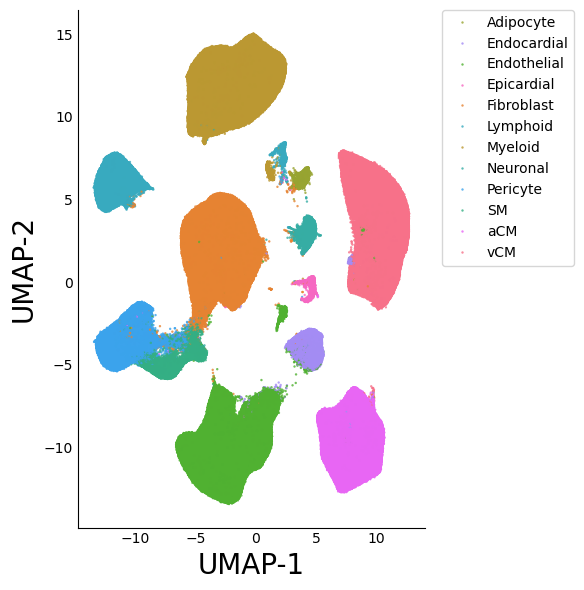

In [32]:
fig, axes = plt.subplots(figsize=(6, 6))
yi = expr.obsm['X_umap']

sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0,
                hue=expr.obs['nn2.celltype'].astype(str))
handles, labels = axes.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axes.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()

In [33]:
### load PCA model from reference RNA data
pca_loadings = pd.read_csv("../../81.FNIH_DPT_IGM_240827/05.R/integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_loadings.csv", index_col=0)
pca_embedding = pd.read_csv("../../81.FNIH_DPT_IGM_240827/05.R/integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_embeddings.csv", index_col=0)
stdev = pd.read_table("../../81.FNIH_DPT_IGM_240827/05.R/integration/coembed/CAREHF_Multiome_DPT_RNA_int_pca_stdev.csv", index_col=0, names = ['stdev'])

In [ ]:
### nvm change
genefilter = gene3c.var.index.get_indexer(pca_loadings.index)
gene3c = gene3c[:, genefilter]

sc.pp.regress_out(gene3c, ['mapped'])
sc.pp.scale(gene3c, max_value=10)
gene3c

In [ ]:
pca_transformed = np.dot(gene3c.X, pca_loadings.values)
X_weighted = pca_transformed/np.array(stdev.index) # weight.by.var = TRUE
gene3c.obsm['X_pca'] = X_weighted

In [ ]:
### run integration
from ALLCools.integration.seurat_class import SeuratIntegration

expr.obs['Modality'] = 'RNA'
gene3c.obs['Modality'] = '3C'
adata_list = [expr, gene3c]
integrator = SeuratIntegration()
anchor = integrator.find_anchor(adata_list,
                                k_local=None,
                                key_local='X_pca',
                                k_anchor=15,
                                key_anchor='X',
                                dim_red='cca',
                                max_cc_cells=50000,
                                k_score=15,
                                k_filter=None,
                                scale1=False,
                                scale2=False,
                                n_components=30,
                                n_features=200,
                                alignments=[[[0], [1]]])

In [ ]:
import time
start_time = time.time()
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=30,
                                 k_weight=15,
                                 sd=1,
                                 alignments=[[[0], [1]]])

print(time.time() - start_time)

In [41]:
### create fake data with joint embedding
ncell = np.sum([xx.shape[0] for xx in adata_list])
adata_merge = anndata.AnnData(
    X=np.ones((ncell, 1)), obs=pd.concat([xx.obs for xx in adata_list], axis=0)
)
adata_merge.obsm['cca'] = np.concatenate(corrected, axis=0)
adata_merge.obsm['X_pca'] = normalize(adata_merge.obsm['cca'][:, :30], axis=1)

adata_merge

AnnData object with n_obs × n_vars = 783067 × 1
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'samples', 'barcode', 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'percent_chrM', 'nCount_ATAC', 'nFeature_ATAC', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res

### Plot co-embedding Hi-C cells

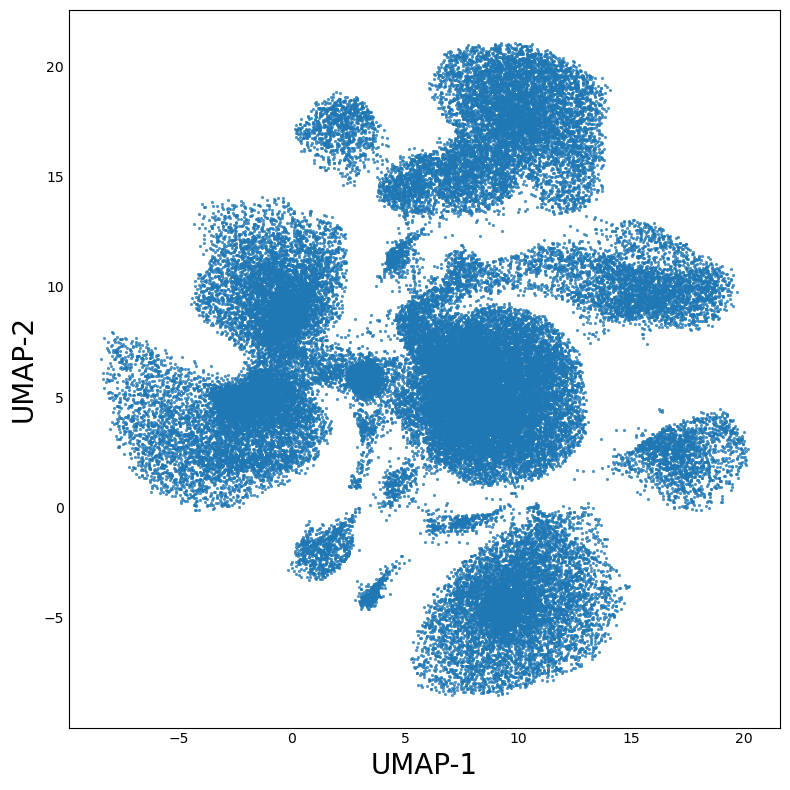

In [48]:
knn = 15
sc.pp.neighbors(adata_merge, n_neighbors=knn, use_rep='cca')
sc.tl.umap(adata_merge, maxiter=200, random_state=42)

fig, axes = plt.subplots(figsize=(8, 8))
gene3c_cell = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C'].index
tmp = adata_merge[adata_merge.obs_names.isin(gene3c_cell)]
yi = tmp.obsm['X_umap']
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=5, alpha=0.8, linewidth=0, legend = False)# , 
                # palette= ccolor.to_dict()['Subclass.color'])

axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()

## Cell type prediction

In [49]:
rna_cell = (adata_merge.obs['Modality']=='RNA')
hic_cell = (adata_merge.obs['Modality']=='3C')
print(rna_cell.sum(), hic_cell.sum())

import pynndescent
start_time = time.time()
index = pynndescent.NNDescent(adata_merge.obsm['cca'][rna_cell], metric='euclidean', 
                              n_neighbors=15, random_state=0, n_jobs=-1)
print(time.time() - start_time)
G, D = index.query(adata_merge.obsm['cca'][hic_cell], k=15)
print(time.time() - start_time)

713384 69683
57.24746084213257
91.6172866821289


In [50]:
chunk_size = 50000
sd = 1

### follow Jingtian's tutorial
### to prevent duplicated point appear
cellfilter = D[:, -1] == 0
D = 1 - D / D[:, -1][:, None]
D[cellfilter] = 1
D = 1 - np.exp(-D * (sd**2) / 4)
D = D / (np.sum(D, axis=1) + 1e-6)[:, None]

In [51]:
rna_cell = rna_cell.index[rna_cell]
hic_cell = hic_cell.index[hic_cell]

enc = OneHotEncoder()
llabel = 'nn2.celltype'
labelref = enc.fit_transform(adata_merge.obs.loc[rna_cell, llabel].astype(str).to_numpy()[:, None])
cluster = pd.DataFrame(index=hic_cell, columns=['rnatype', 'score'], dtype=str)
nn = []
for chunk_start in range(0, len(hic_cell), chunk_size):
    result = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()]
        .toarray()
        .reshape((-1, 15, enc.categories_[0].shape[0]))
    ).sum(axis=1)
    result = pd.DataFrame(
        result,
        columns=enc.categories_[0],
        index=hic_cell[chunk_start : (chunk_start + chunk_size)],
    )
    result = result.loc[:, result.columns != "nan"]
    nn.append(result)
    cluster.loc[result.index, "rnatype"] = result.idxmax(axis=1).values
    cluster.loc[result.index, "score"] = result.max(axis=1).values
    print(chunk_start)

print(time.time() - start_time)

0
50000
92.08704280853271


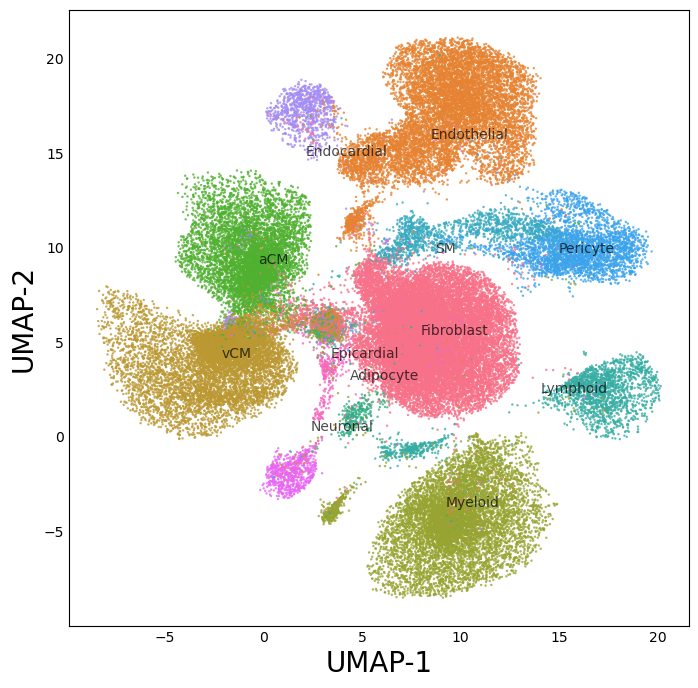

In [52]:
fig, axes = plt.subplots(figsize=(8, 8))
gene3c_cell = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C'].index
tmp = adata_merge[adata_merge.obs_names.isin(gene3c_cell)]
yi = tmp.obsm['X_umap']
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, 
                hue=cluster.loc[tmp.obs.index]['rnatype'], legend = False) 

### manually label point
representative_points = []
for cls in np.unique(cluster.loc[tmp.obs.index]['rnatype']):
    cluster_indices = np.where(cluster.loc[tmp.obs.index]['rnatype'] == cls)[0]
    centroid = np.mean(yi[cluster_indices], axis=0)
    representative_points.append(centroid)

for i, label in enumerate(np.unique(cluster.loc[tmp.obs.index]['rnatype'])):
    plt.annotate(label, (representative_points[i][0], representative_points[i][1]), fontsize=10, alpha=0.7)

axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.tick_params(axis='both', which='both', length=0)

In [53]:
### leiden clustering
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph

embedding = adata_merge.obsm['cca']

# Create an instance of the kNN graph object
data = pd.DataFrame((embedding))
knn_graph = kneighbors_graph(data, n_neighbors=15, mode='connectivity', include_self=False)

# Convert the sparse matrix to an igraph object
g = ig.Graph.Weighted_Adjacency(knn_graph)

# Assign vertex attributes
g.vs['embedding'] = (embedding)
partition = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter=1)
leiden_idt = [str(i) for i in partition.membership]

adata_merge.obs['leiden_1'] = leiden_idt
gene3c.obs['leiden_1'] = adata_merge.obs.loc[gene3c.obs.index]['leiden_1']
gene3c.obs[['predicted.id', 'predicted.score']] = cluster.loc[gene3c.obs_names]

## Output for ProjectUMAP

In [54]:
gene3c.obs.to_csv('integration/FNIH_DHC_genescore_prediction.metadata.csv')
gene3c.obs['predicted.score'] = gene3c.obs['predicted.score'].astype(str) # fix some stuff
gene3c.write_h5ad('integration/FNIH_DHC_genescore.prediction.h5ad')
adata_merge.write_h5ad("integration/FNIH_DHC_genescore_joint_embedding.h5ad")

... storing 'Modality' as categorical
... storing 'leiden_1' as categorical
... storing 'predicted.id' as categorical
... storing 'predicted.score' as categorical
... storing 'leiden_1' as categorical
